Enter calorie limit (e.g. 2000):  1200


Running GA Variants...

Generation 1/50 (memetic=False, parallel=False)
Generation 11/50 (memetic=False, parallel=False)
Generation 21/50 (memetic=False, parallel=False)
Generation 31/50 (memetic=False, parallel=False)
Generation 41/50 (memetic=False, parallel=False)
Generation 50/50 (memetic=False, parallel=False)
Basic GA runtime: 1.52 seconds

Generation 1/50 (memetic=False, parallel=True)
Generation 11/50 (memetic=False, parallel=True)
Generation 21/50 (memetic=False, parallel=True)
Generation 31/50 (memetic=False, parallel=True)
Generation 41/50 (memetic=False, parallel=True)
Generation 50/50 (memetic=False, parallel=True)
Parallel GA runtime: 0.46 seconds

Generation 1/50 (memetic=True, parallel=True)
Generation 11/50 (memetic=True, parallel=True)
Generation 21/50 (memetic=True, parallel=True)
Generation 31/50 (memetic=True, parallel=True)
Generation 41/50 (memetic=True, parallel=True)
Generation 50/50 (memetic=True, parallel=True)
Memetic GA runtime: 24.50 seconds


GA Variant R

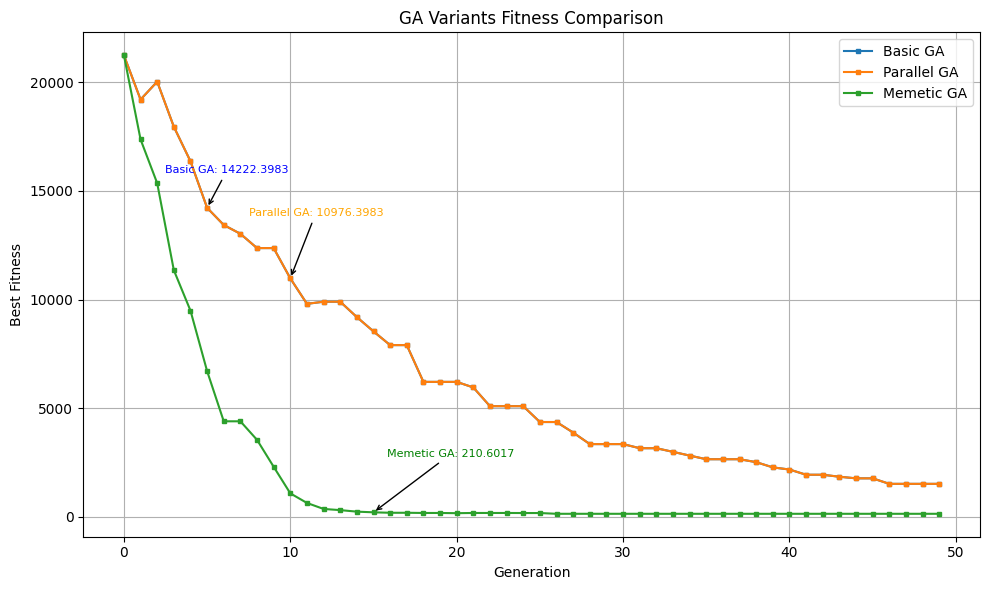

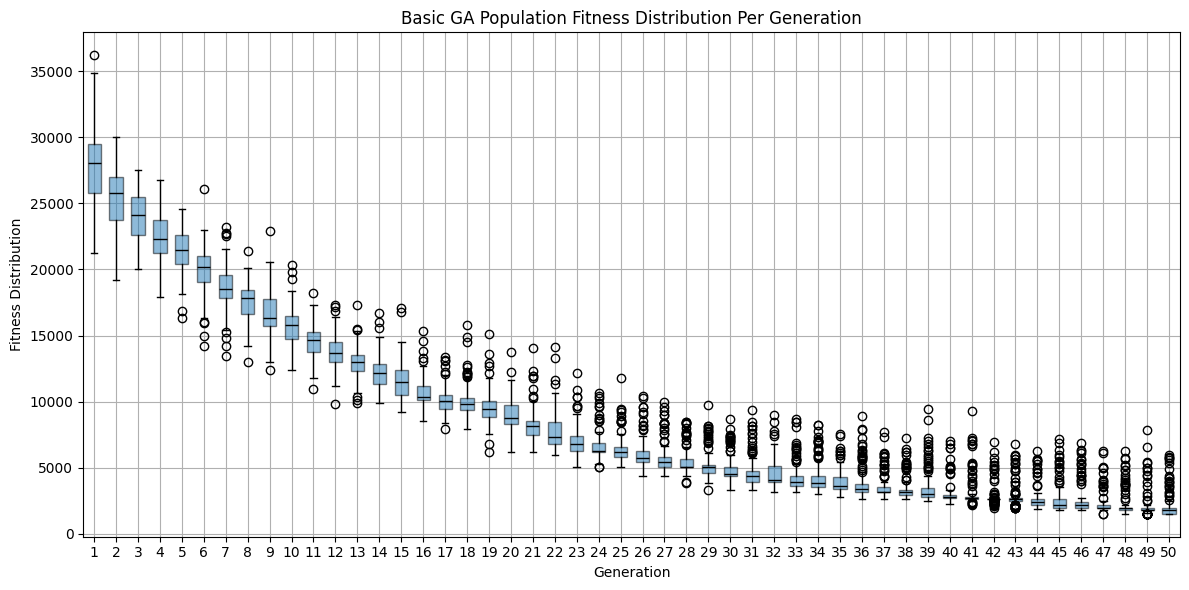

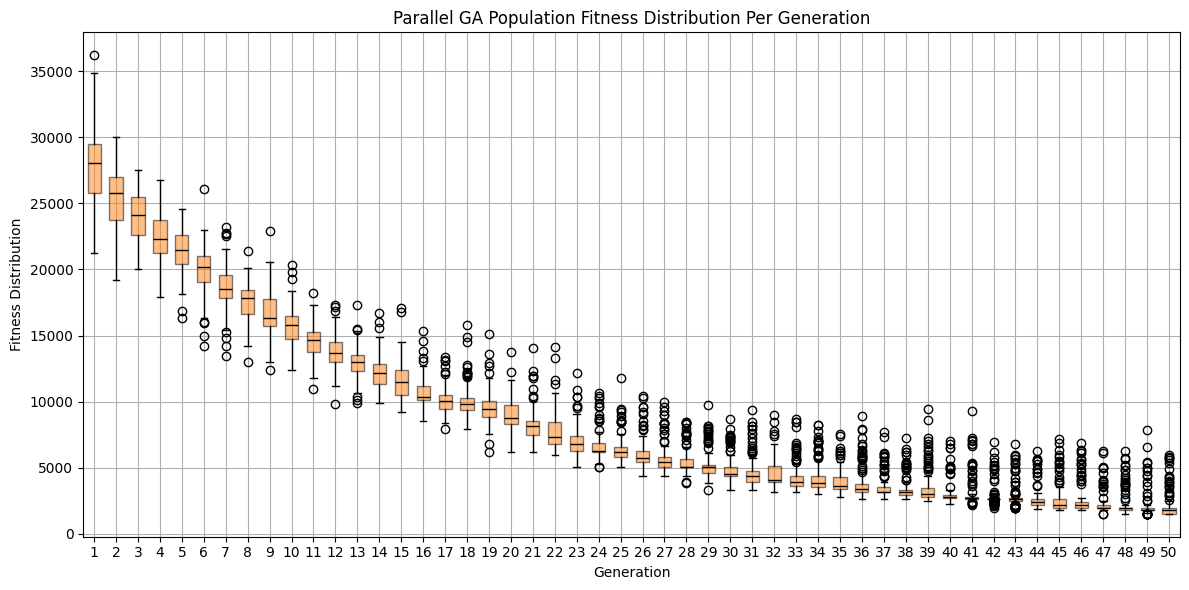

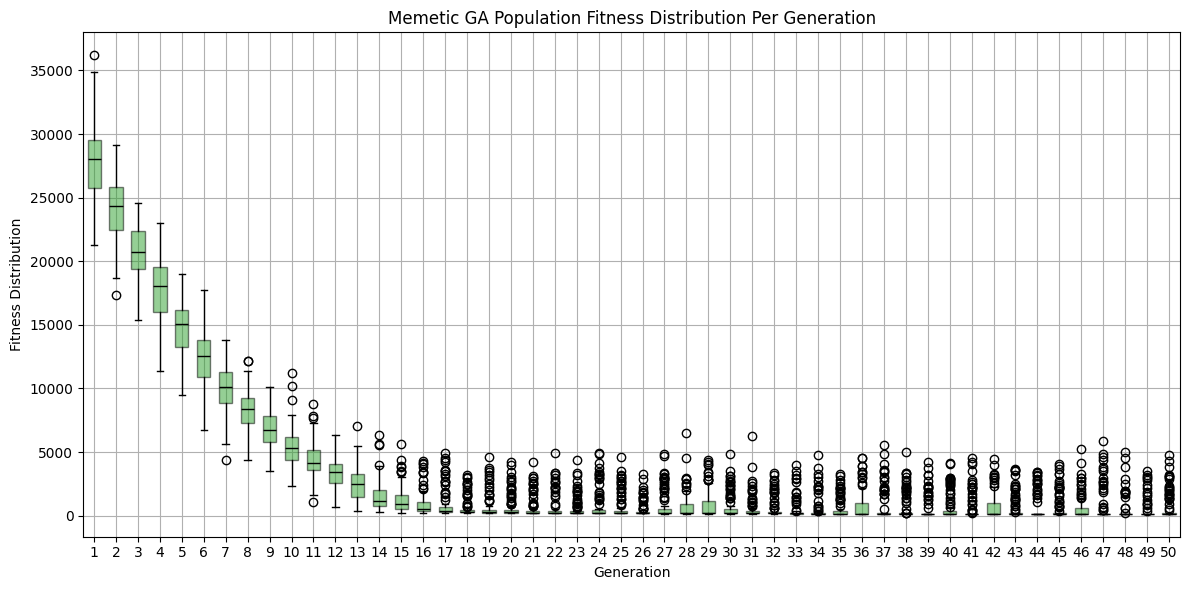

In [1]:
# -----------------------------------------------
# IMPORTING REQUIRED LIBRARIES
# -----------------------------------------------

import pandas as pd  # For loading and handling tabular data (like recipes and nutrition)
import numpy as np  # For numerical operations and array handling
import random  # For generating random numbers (used in initialization, crossover, mutation)
import multiprocessing  # For parallel processing (used in Parallel GA)
import time  # For tracking execution time and generating timestamps
import matplotlib.pyplot as plt  # For creating plots and visualizations
from deap import base, creator, tools  # DEAP: Library for Genetic Algorithms (used to define GA logic)

# -----------------------------------------------
# USER CONFIGURATION
# -----------------------------------------------

calories_target = float(input("Enter calorie limit (e.g. 2000): "))

protein_target = random.uniform(120, 180)
carbs_target = random.uniform(200, 300)
fat_target = random.uniform(50, 90)

meal_limits = {
    "Breakfast": 1,
    "Entrée": 2,
    "Protein": 2,
    "Side": 1,
    "Soup": 1
}

meal_df = pd.read_csv("Recipes@.csv")
nutrient_columns = ["Calories", "Protein", "Carbs", "Fat"]
nutrient_data = meal_df[nutrient_columns].to_numpy()
target_nutrients = np.array([calories_target, protein_target, carbs_target, fat_target])
chromosome_length = len(meal_df)

NUM_NUTRIENTS = len(target_nutrients)
NGEN = 50
POP_SIZE = 100
CROSSOVER_PROB = 0.5
MUTATION_PROB = 0.2
TIMESTAMP = int(time.time() * 1000) % 2**32

# -----------------------------------------------
# FITNESS FUNCTION
# -----------------------------------------------

def diet_fitness(individual):
    _ = sum(i ** 2 for i in range(10000))  # ~1ms CPU work
    selected = np.array(individual)
    totals = selected @ nutrient_data
    deviation = np.abs(totals - target_nutrients)
    penalty = 0
    for meal_type, max_allowed in meal_limits.items():
        indices = meal_type_to_indices.get(meal_type, [])
        count = sum(individual[i] for i in indices)
        if count > max_allowed:
            penalty += (count - max_allowed) * 100
    return (np.sum(deviation) + penalty,)

# -----------------------------------------------
# GA TOOLBOX SETUP
# -----------------------------------------------

def setup_toolbox():
    if hasattr(creator, "FitnessMin"):
        delattr(creator, "FitnessMin")
    if hasattr(creator, "Individual"):
        delattr(creator, "Individual")

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", lambda: random.randint(0, 1))
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, chromosome_length)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", diet_fitness)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    return toolbox

# -----------------------------------------------
# UTILITIES
# -----------------------------------------------

def evaluate_population(toolbox, population):
    invalid = [ind for ind in population if not ind.fitness.valid]
    fits = list(map(toolbox.evaluate, invalid))
    for ind, fit in zip(invalid, fits):
        ind.fitness.values = fit

def evaluate_population_parallel(toolbox, population):
    invalid = [ind for ind in population if not ind.fitness.valid]
    if not invalid:
        return
    fits = toolbox.map(toolbox.evaluate, invalid)
    for ind, fit in zip(invalid, fits):
        ind.fitness.values = fit

def local_search(individual, n_steps=10):
    best = creator.Individual(individual)
    best_fit = diet_fitness(best)[0]

    for _ in range(n_steps):
        neighbor = creator.Individual(best)
        i = random.randint(0, len(neighbor) - 1)
        neighbor[i] = 1 - neighbor[i]
        fit = diet_fitness(neighbor)[0]
        if fit < best_fit:
            best, best_fit = neighbor, fit
    return best

def print_best_solution(name, individual):
    nutrient_cols = ["Calories", "Protein", "Carbs", "Fat"]
    display_names = ["Calories", "Protein (g)", "Carbs (g)", "Fat (g)"]

    print(f"\n{name} Best Meal Plan:")

    selected_indices = [i for i, val in enumerate(individual) if val == 1]
    selected_meals = meal_df.iloc[selected_indices]

    print(f"{'Meal':<10} | {'Recipe Name':<65} | {'Cal':>5} | {'P':>3} | {'C':>3} | {'F':>3}")
    print("-" * 78)
    for _, row in selected_meals.iterrows():
        print(f"{row['Meal']:<10} | {row['RecipeName']:<65} | "
              f"{row['Calories']:5} | {row['Protein']:3} | {row['Carbs']:3} | {row['Fat']:3}")

    totals = selected_meals[nutrient_cols].sum()

    pct_of_total = totals / totals["Calories"] * 100
    pct_of_target = totals / target_nutrients * 100

    print("\nSummary (Totals and % of Targets):")
    print(f"{'Nutrient':<12} {'Total':>8} {'Target':>8} {'% of Total':>12} {'% of Target':>12}")
    print("-" * 56)

    for i, nutrient in enumerate(nutrient_cols):
        print(f"{display_names[i]:<12} "
              f"{totals[nutrient]:8.1f} "
              f"{target_nutrients[i]:8.1f} "
              f"{pct_of_total.iloc[i]:12.1f}% "
              f"{pct_of_target.iloc[i]:12.1f}%")

    fitness_val = diet_fitness(individual)[0]
    print(f"\nFitness: {fitness_val:.1f}")

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

meal_type_to_indices = {}
for i, meal_type in enumerate(meal_df["Meal"]):
    meal_type_to_indices.setdefault(meal_type, []).append(i)

# -----------------------------------------------
# GA RUNNER
# -----------------------------------------------

def run_ga(memetic=False, parallel=True):
    set_seeds(TIMESTAMP)
    toolbox = setup_toolbox()

    if parallel:
        pool = multiprocessing.Pool()
        toolbox.register("map", pool.map)
    else:
        toolbox.register("map", map)

    pop = toolbox.population(n=POP_SIZE)

    if parallel:
        evaluate_population_parallel(toolbox, pop)
    else:
        evaluate_population(toolbox, pop)

    best_per_gen = []
    all_fitness = []

    for gen in range(NGEN):
        if gen % 10 == 0 or gen == NGEN-1:
            print(f"Generation {gen+1}/{NGEN} (memetic={memetic}, parallel={parallel})")

        fitness_vals = [ind.fitness.values[0] for ind in pop]
        all_fitness.append(fitness_vals)
        best = tools.selBest(pop, 1)[0]
        best_per_gen.append(best.fitness.values[0])

        offspring = list(map(toolbox.clone, toolbox.select(pop, len(pop))))

        for i in range(1, len(offspring), 2):
            if random.random() < CROSSOVER_PROB:
                toolbox.mate(offspring[i-1], offspring[i])
                del offspring[i-1].fitness.values
                del offspring[i].fitness.values

        for i in range(len(offspring)):
            if random.random() < MUTATION_PROB:
                toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

            if memetic:
                offspring[i][:] = local_search(offspring[i])

        if parallel:
            evaluate_population_parallel(toolbox, offspring)
        else:
            evaluate_population(toolbox, offspring)

        pop[:] = offspring

    if parallel:
        pool.close()
        pool.join()

    best = tools.selBest(pop, 1)[0]
    return best_per_gen, best, all_fitness

# -----------------------------------------------
# RUNTIME TABLE
# -----------------------------------------------

def print_runtime_table(basic, parallel, memetic):
    def pct_speedup(base, other):
        return (1 - other / base) * 100

    print("\nGA Variant Runtime Summary:")
    print(f"{'Variant':<15}{'Time (s)':>10}{'Speed Change':>30}")
    print("-" * 45)

    print(f"{'Basic GA':<15}{basic:10.2f}{'Baseline':>30}")

    parallel_diff = pct_speedup(basic, parallel)
    print(f"{'Parallel GA':<15}{parallel:10.2f}{abs(parallel_diff):19.1f}% {'faster' if parallel_diff > 0 else 'slower'}")

    memetic_diff = pct_speedup(basic, memetic)
    memetic_label = f"{abs(memetic_diff):.1f}% {'faster' if memetic_diff > 0 else 'slower'}"
    print(f"{'Memetic GA':<15}{memetic:10.2f}{memetic_label:>20}")


# -----------------------------------------------
# MAIN
# -----------------------------------------------

if __name__ == "__main__":
    print("Running GA Variants...\n")

    start = time.time()
    fitness_basic, best_basic, all_basic = run_ga(memetic=False, parallel=False)
    duration_basic = time.time() - start
    print(f"Basic GA runtime: {duration_basic:.2f} seconds\n")

    start = time.time()
    fitness_parallel, best_parallel, all_parallel = run_ga(memetic=False, parallel=True)
    duration_parallel = time.time() - start
    print(f"Parallel GA runtime: {duration_parallel:.2f} seconds\n")

    start = time.time()
    fitness_memetic, best_memetic, all_memetic = run_ga(memetic=True, parallel=True)
    duration_memetic = time.time() - start
    print(f"Memetic GA runtime: {duration_memetic:.2f} seconds\n")

    print_runtime_table(duration_basic, duration_parallel, duration_memetic)

    print_best_solution("Basic GA", best_basic)
    print_best_solution("Parallel GA", best_parallel)
    print_best_solution("Memetic GA", best_memetic)

    # --- All Plots ---
    plt.figure(figsize=(10, 6))
    
    # Line plots with markers
    plt.plot(fitness_basic, label='Basic GA', marker='s', markersize=3)
    plt.plot(fitness_parallel, label='Parallel GA', marker='s', markersize=3)
    plt.plot(fitness_memetic, label='Memetic GA', marker='s', markersize=3)
    
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("GA Variants Fitness Comparison")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Annotated points
    n = len(fitness_basic)
    idx_basic = int(n * 0.10)
    idx_parallel = int(n * 0.20)
    idx_memetic = int(n * 0.30)
    
    plt.annotate(f"Basic GA: {fitness_basic[idx_basic]:.4f}",
                 xy=(idx_basic, fitness_basic[idx_basic]),
                 xytext=(-30, 25), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'), fontsize=8, color='blue')
    
    plt.annotate(f"Parallel GA: {fitness_parallel[idx_parallel]:.4f}",
                 xy=(idx_parallel, fitness_parallel[idx_parallel]),
                 xytext=(-30, 45), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'), fontsize=8, color='orange')
    
    plt.annotate(f"Memetic GA: {fitness_memetic[idx_memetic]:.4f}",
                 xy=(idx_memetic, fitness_memetic[idx_memetic]),
                 xytext=(10, 40), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'), fontsize=8, color='green')
    
    plt.show()

    # Separate boxplots per GA variant for clarity
    for ga_data, name, color in [
        (all_basic, 'Basic GA', 'C0'),
        (all_parallel, 'Parallel GA', 'C1'),
        (all_memetic, 'Memetic GA', 'C2')
    ]:
        plt.figure(figsize=(12, 6))
        plt.boxplot(
            ga_data,
            positions=range(1, NGEN + 1),
            widths=0.6,
            patch_artist=True,
            boxprops=dict(facecolor=color, alpha=0.5),
            medianprops=dict(color='black')
        )
        plt.xlabel("Generation")
        plt.ylabel("Fitness Distribution")
        plt.title(f"{name} Population Fitness Distribution Per Generation")
        plt.xticks(range(1, NGEN + 1))
        plt.grid(True)
        plt.tight_layout()
        plt.show()
